In [1]:
#! pip install -U pip setuptools wheel
#! pip install -U 'spacy[cuda12x]'
#! python -m spacy download en_core_web_trf
#! python -m spacy download en_core_web_sm
#! pip install pandas

### Baixar CSV DAtaset

Para realizar o tratamento de dados a seguir, o IMDB Dataset deve ser baixado, e colocado na pasta raiz do projeto

<a href="https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" target="_blank">Conjunto de dados IMDB de 50 mil críticas de filmes</a>


In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from spacy.tokens import Doc
from tqdm import tqdm

In [3]:
# Carregar o modelo em inglês
nlp = spacy.load("en_core_web_sm", exclude=["parser", "ner"])

FILE_PATH = "D:/tcc2/guilherme/3_Data_Processing/data/scrapper_reviews_english_original.csv" 

df = pd.read_csv(FILE_PATH)
df = df[['review','rating']]
df

,review,rating
0,This movie takes place off in fantasy land som...,1
1,"Too sentimental, too pathetic, too slow, too c...",1
2,There are some things in this life we will nev...,1
3,This movie was inspired by the brilliant Stir ...,1
4,"For the life of me, I can't understand all the...",1
...,...,...
44422,"Uma Thurman returns as the Bride, who this tim...",10
44423,"Quentin Tarantino's ""Kill Bill: Vol. 2"" comple...",10
44424,Vol 2 is completely different tone then the fi...,10
44425,This movie is great in that it mixes together ...,10


In [4]:
df.isnull().sum()

review    0
rating    0
dtype: int64

In [5]:
df.duplicated().sum()

16

In [6]:
# Remove linhas de reviews_treated duplicadoss
df = df.drop_duplicates()

In [7]:
df.duplicated().sum()

0

In [8]:
df["rating"].value_counts()

rating
10    6231
8     6225
9     6217
7     5799
6     4649
5     3741
1     3443
4     2960
3     2726
2     2420
Name: count, dtype: int64

In [9]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_qtd_tokens(x, tokenizer):
    tokens = bert_tokenizer.tokenize(x)
    return len(tokens)



In [10]:
# Calcular o tamanho dos textos
qtd_tokens = df['review'].apply(lambda x: get_qtd_tokens(x, bert_tokenizer))
df = df.assign(qtd_tokens =qtd_tokens )
df


,review,rating,qtd_tokens
0,This movie takes place off in fantasy land som...,1,78
1,"Too sentimental, too pathetic, too slow, too c...",1,41
2,There are some things in this life we will nev...,1,395
3,This movie was inspired by the brilliant Stir ...,1,162
4,"For the life of me, I can't understand all the...",1,109
...,...,...,...
44422,"Uma Thurman returns as the Bride, who this tim...",10,315
44423,"Quentin Tarantino's ""Kill Bill: Vol. 2"" comple...",10,860
44424,Vol 2 is completely different tone then the fi...,10,48
44425,This movie is great in that it mixes together ...,10,134


In [11]:
df['qtd_tokens'].describe()

count    44411.000000
mean       298.141632
std        266.708233
min          6.000000
25%        135.000000
50%        217.000000
75%        379.000000
max       2223.000000
Name: qtd_tokens, dtype: float64

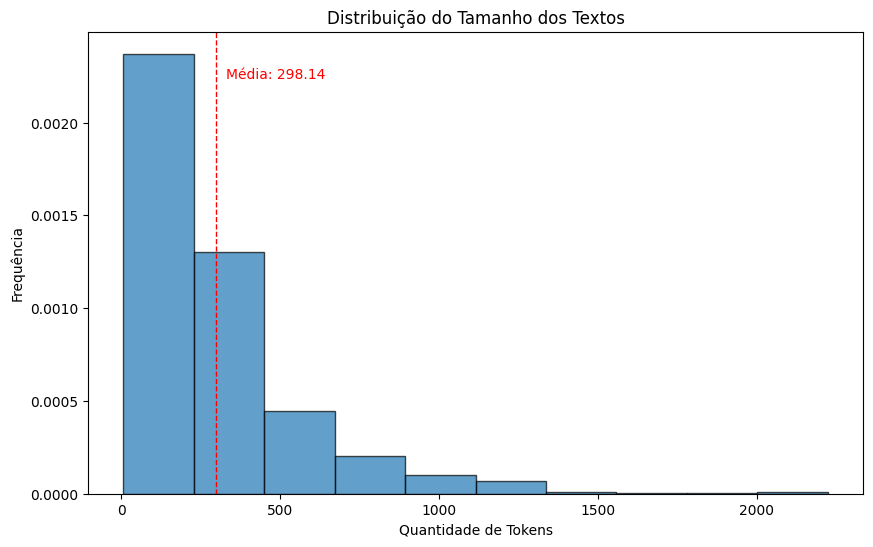

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

# Plotar o gráfico
def plot_graf_qnt_tokens(series_list):
    
    mean_length = series_list.mean()
    
    plt.figure(figsize=(10, 6))
    plt.hist(series_list, edgecolor='k', alpha=0.7, density=True)  # Adicione o argumento density=True
    plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1)
    plt.text(mean_length*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length:.2f}', color='r')

    # # Adicionar a linha de densidade
    # density = gaussian_kde(df['qtd_tokens'])
    # xs = np.linspace(df['qtd_tokens'].min(), df['qtd_tokens'].max(), 200)
    # plt.plot(xs, density(xs), color='blue')

    plt.title('Distribuição do Tamanho dos Textos')
    plt.xlabel('Quantidade de Tokens')
    plt.ylabel('Frequência')
    plt.show()

plot_graf_qnt_tokens(df['qtd_tokens'])

### Remocao de outliers

In [13]:
def remove_outliers(df, column):
    # Calcular o IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    print(f"Q1: {Q1}")
    print(f"Q3: {Q3}")
    print(f"IQR: {IQR}")

    # Definir os limites para outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Limite inferior: {lower_bound}")
    print(f"Limite superior: {upper_bound}")

    # Remover outliers
    df_without_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print(f"Número de outliers removidos: {len(df) - len(df_without_outliers)}")

    return df_without_outliers


print("Df com outliers: ", df["qtd_tokens"].size)
df_without_outliers = remove_outliers(df, "qtd_tokens")
print("Df sem outliers: ", df_without_outliers["review"].size)
df_without_outliers["qtd_tokens"].describe()

Df com outliers:  44411
Q1: 135.0
Q3: 379.0
IQR: 244.0
Limite inferior: -231.0
Limite superior: 745.0
Número de outliers removidos: 3086
Df sem outliers:  41325


count    41325.000000
mean       242.968566
std        163.347642
min          6.000000
25%        128.000000
50%        202.000000
75%        333.000000
max        745.000000
Name: qtd_tokens, dtype: float64

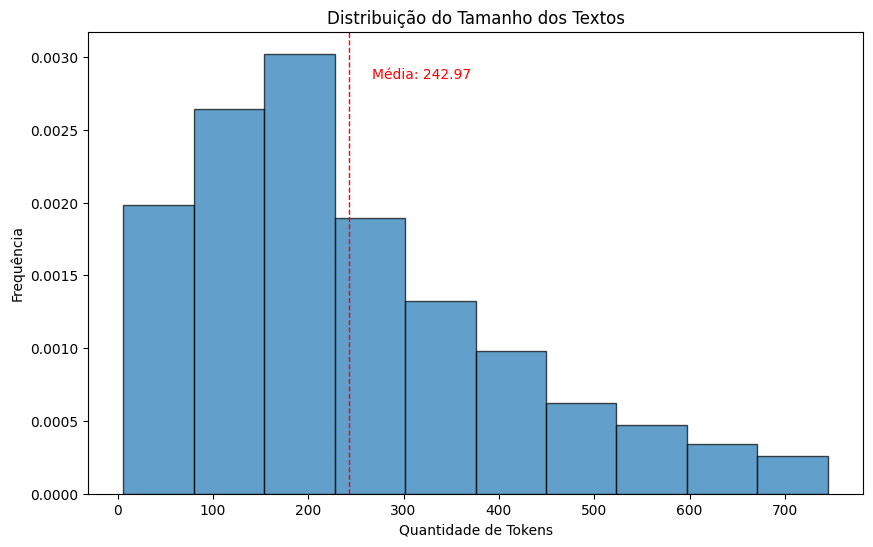

In [14]:
plot_graf_qnt_tokens(df_without_outliers['qtd_tokens'])

In [15]:
print("Max value in df sem outliers:")
df['qtd_tokens'].describe()


Max value in df sem outliers:


count    44411.000000
mean       298.141632
std        266.708233
min          6.000000
25%        135.000000
50%        217.000000
75%        379.000000
max       2223.000000
Name: qtd_tokens, dtype: float64

In [16]:
print("Max value in df com outliers:")
df_without_outliers.describe()


Max value in df com outliers:


,rating,qtd_tokens
count,41325.000000,41325.000000
mean,6.282202,242.968566
std,2.796466,163.347642
min,1.000000,6.000000
25%,4.000000,128.000000
50%,7.000000,202.000000
75%,9.000000,333.000000
max,10.000000,745.000000


In [17]:
df = df_without_outliers

In [18]:
DATA_PATH = f"D:/tcc2/guilherme/3_Data_Processing/data/Scraper_Dataset_english_sem_outliers.csv"
df.to_csv(DATA_PATH, index=False)

#### Funcoes para pre-processamento


In [19]:
# O tokenizador do Bert já faz isso
def remove_extra_spaces(text):
    r"""Remover espacos, quebra de linhas e tabulações do inicio
    e fim de frases e ubstituir sequências de espaços
    por um espaço"""

    return re.sub(r"\s+", " ", text).strip()



# Não usar nos dados do scraper
def remove_tags(raw_text):
    r"""Remove tags HTML <.*?>, mas pode remover texto destacado."""
    cleaned_text = re.sub(re.compile("<.*?>"), "", raw_text)

    return cleaned_text


# O tokenizer bert-base-uncased faz automaticamente
def normalize_lowercase(text: str) -> str:
    r"""Converte todas as palavras para forma minuscula"""
    return text.lower()


def remove_stopwords_and_puntuaction(doc: Doc | str):
    r"""Remove pontuacoes,remove stop_words,
    e retorna so o texto"""
    if not isinstance(doc, Doc):

        doc = nlp(doc)

    return " ".join(
        [token.text for token in doc if not token.is_stop and not token.is_punct]
    )

# funcoes de tratamento spacy
def lemmatize_text_remove_stopwords_and_puntuaction(doc: Doc | str):
    r"""Reduz a palavra a lemma, remove pontuacoes,
    remove stop_words"""
    if not isinstance(doc, Doc):

        doc = nlp(doc)

    return " ".join(
        [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    )



# funcoes ilustrativas, são muito ineficientes para serem usadas sozinhas
# def remove_punctuation(doc):
#     return " ".join([token.text for token in doc if not token.is_punct])



# def remove_stopwords(doc):
#     return " ".join([token.text for token in doc if not token.is_stop])



# def lemmatize_text(doc):
#     return " ".join([token.lemma_ for token in doc])

In [20]:
from typing import List, Literal
from tqdm import tqdm


def execute_all_trataments(
    series_review: pd.Series, FINAL_SPACY_FORMAT: Literal["lemma", "text"]
) -> List[str]:
    if FINAL_SPACY_FORMAT not in ["lemma", "text"]:
        raise ValueError("FINAL_SPACY_FORMAT != [lemma | text]")

    reviews_treated = series_review

    # reviews_treated = reviews_treated.apply(remove_tags)
    # reviews_treated = reviews_treated.apply(normalize_lowercase)
    reviews_treated = reviews_treated.apply(remove_extra_spaces)

    len_texts = len(reviews_treated)

    docs = list(
        tqdm(
            nlp.pipe(
                reviews_treated,
                batch_size=1000,
                disable=["parser", "ner"],
            ),
            colour="green",
            desc="Progresso: ",
            total=len_texts,
        )
    )

    if FINAL_SPACY_FORMAT == "lemma":

        reviews_treated = [
            lemmatize_text_remove_stopwords_and_puntuaction(doc) for doc in docs
        ]

    elif FINAL_SPACY_FORMAT == "text":

        reviews_treated = [remove_stopwords_and_puntuaction(doc) for doc in docs]

    reviews_treated = [remove_extra_spaces(review) for review in reviews_treated]

    return reviews_treated

In [21]:
# Aplicar as funções de str ao DataFrame
# definir como True para saída em forma de token.lemma, ou False para token.text
FINAL_SPACY_FORMAT= "lemma" 
reviews_treated= execute_all_trataments(df["review"],FINAL_SPACY_FORMAT)

Progresso: 100%|██████████| 41325/41325 [06:21<00:00, 108.20it/s]


In [22]:
reviews_treated

['movie take place fantasy land absolutely ridiculous brain know real world work fall fairy tale watch escape Alcatraz rip badly Alcatraz original add extra star Tim Robbins look beautiful darling',
 'sentimental pathetic slow conventionally voice explain ruin completely make boring hell far overrated film time',
 'thing life understand universe begin happen soul die movie bland Shawshank Redemption overrated?in case certain movie understand reason overrate Shawshank Redemption average cliché ride film moral basically hope important wrong heck problem simplicity problem past simple land simplistic movie treat borrow plot part Count Monte Cristo banal theme freshly mint nugget wisdom complain pretend pleasant diversion shot movie reveal true condescend colour end moment early instead poetic shot sea respect superior original story end director spell thing audience Frank Darabont know tell story know tell originality depth movie partially redeem thing majestic cinematography powerful sco

In [23]:
df["review"]= reviews_treated


C:\Users\Guilherme\AppData\Local\Temp\ipykernel_4764\812141549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review"]= reviews_treated


In [24]:
df.duplicated(subset=["review", "rating"]).sum()


13

In [25]:
df = df.drop_duplicates(subset=["review", "rating"], ignore_index=True)

In [26]:
df

,review,rating,qtd_tokens
0,movie take place fantasy land absolutely ridic...,1,78
1,sentimental pathetic slow conventionally voice...,1,41
2,thing life understand universe begin happen so...,1,395
3,movie inspire brilliant Stir Crazy star Gene W...,1,162
4,life understand gush cornball sentimental phon...,1,109
...,...,...,...
41307,bloody good time Vol 1 watch Uma Thurman slice...,10,289
41308,Uma Thurman return Bride time look continue st...,10,315
41309,Vol 2 completely different tone feature film a...,10,48
41310,movie great mix different genre movie martial ...,10,134


In [27]:
df=df.drop(columns=['qtd_tokens'])


In [28]:
df

,review,rating
0,movie take place fantasy land absolutely ridic...,1
1,sentimental pathetic slow conventionally voice...,1
2,thing life understand universe begin happen so...,1
3,movie inspire brilliant Stir Crazy star Gene W...,1
4,life understand gush cornball sentimental phon...,1
...,...,...
41307,bloody good time Vol 1 watch Uma Thurman slice...,10
41308,Uma Thurman return Bride time look continue st...,10
41309,Vol 2 completely different tone feature film a...,10
41310,movie great mix different genre movie martial ...,10


In [29]:
# Calcular o tamanho dos textos
qtd_tokens = df['review'].apply(lambda x: get_qtd_tokens(x, bert_tokenizer))


In [30]:
df = df.assign(qtd_tokens=qtd_tokens) 
df 


,review,rating,qtd_tokens
0,movie take place fantasy land absolutely ridic...,1,34
1,sentimental pathetic slow conventionally voice...,1,17
2,thing life understand universe begin happen so...,1,140
3,movie inspire brilliant Stir Crazy star Gene W...,1,84
4,life understand gush cornball sentimental phon...,1,38
...,...,...,...
41307,bloody good time Vol 1 watch Uma Thurman slice...,10,117
41308,Uma Thurman return Bride time look continue st...,10,156
41309,Vol 2 completely different tone feature film a...,10,16
41310,movie great mix different genre movie martial ...,10,60


In [31]:
df['qtd_tokens'].describe()


count    41312.000000
mean       101.904604
std         71.575228
min          1.000000
25%         50.000000
50%         83.000000
75%        140.000000
max        422.000000
Name: qtd_tokens, dtype: float64

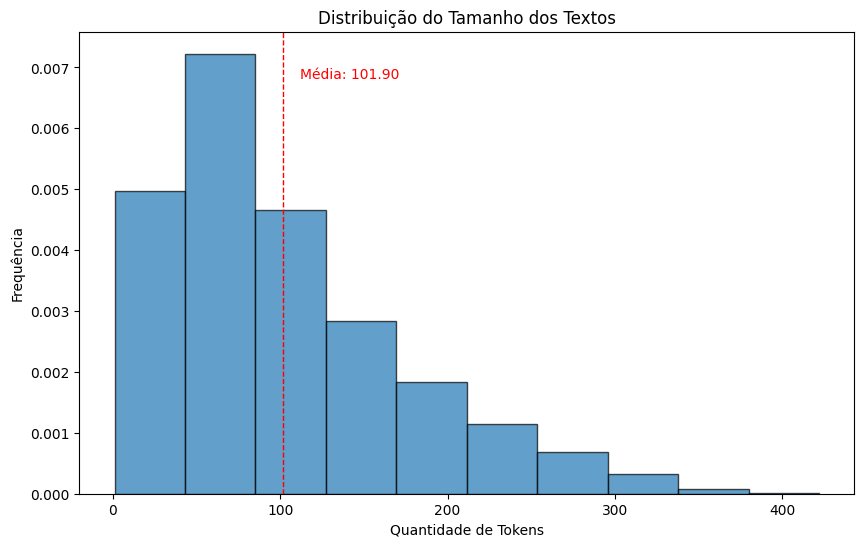

In [32]:
plot_graf_qnt_tokens(df['qtd_tokens'])

In [33]:
df_text_sem_outliers = remove_outliers(df, "qtd_tokens")
df_text_sem_outliers

Q1: 50.0
Q3: 140.0
IQR: 90.0
Limite inferior: -85.0
Limite superior: 275.0
Número de outliers removidos: 1198


,review,rating,qtd_tokens
0,movie take place fantasy land absolutely ridic...,1,34
1,sentimental pathetic slow conventionally voice...,1,17
2,thing life understand universe begin happen so...,1,140
3,movie inspire brilliant Stir Crazy star Gene W...,1,84
4,life understand gush cornball sentimental phon...,1,38
...,...,...,...
41307,bloody good time Vol 1 watch Uma Thurman slice...,10,117
41308,Uma Thurman return Bride time look continue st...,10,156
41309,Vol 2 completely different tone feature film a...,10,16
41310,movie great mix different genre movie martial ...,10,60


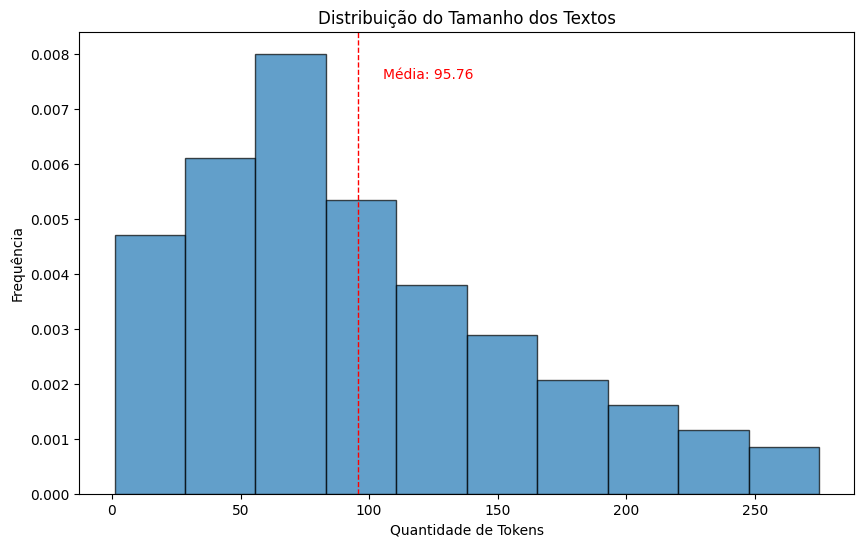

In [34]:
plot_graf_qnt_tokens(df_text_sem_outliers['qtd_tokens'])

In [35]:
df_text_sem_outliers.describe()

,rating,qtd_tokens
count,40114.000000,40114.000000
mean,6.236451,95.761330
std,2.800286,62.873044
min,1.000000,1.000000
25%,4.000000,49.000000
50%,7.000000,81.000000
75%,9.000000,133.000000
max,10.000000,275.000000


In [36]:
df = df_text_sem_outliers

In [37]:
FINAL_SPACY_FORMAT

'lemma'

In [38]:
DATA_PATH = f"D:/tcc2/guilherme/3_Data_Processing/data/Scraper_Dataset_treated_{FINAL_SPACY_FORMAT}_sem_outliers.csv"
df.to_csv(DATA_PATH, index=False)

## Vizualizacao dos dados após tratamento

carregar csv já tratado


In [39]:
import pandas as pd


DATA_PATH = f"D:/tcc2/guilherme/3_Data_Processing/data/Scraper_Dataset_treated_text_sem_outliers.csv"
df = pd.read_csv(DATA_PATH)

In [40]:
# import collections

# # Concatenar todas as avaliações em uma única string
# all_reviews = ' '.join(df['review'])

# # Dividir a string em palavras
# words = all_reviews.split()

# # Contar a frequência de cada palavra
# word_counts = collections.Counter(words)

# # Exibir as 10 palavras mais comuns
# for word, count in word_counts.most_common(-10):
#     print(f'Palavra: {word}, Frequência: {count}')

# len(word_counts)

In [41]:
# import numpy as np

# # Calcular estatísticas básicas
# frequencies = list(word_counts.values())
# mean_freq = np.mean(frequencies)
# median_freq = np.median(frequencies)
# min_freq = np.min(frequencies)
# max_freq = np.max(frequencies)
# std_freq = np.std(frequencies)

# print(f"Média de frequência: {mean_freq}")
# print(f"Mediana de frequência: {median_freq}")
# print(f"Frequência mínima: {min_freq}")
# print(f"Frequência máxima: {max_freq}")
# print(f"Desvio padrão de frequência: {std_freq}")

# # Calcular o IQR
# Q1 = np.percentile(frequencies, 25)
# Q3 = np.percentile(frequencies, 75)
# IQR = Q3 - Q1

# # Identificar outliers
# outliers = [freq for freq in frequencies if freq < Q1 - 1.5 * IQR or freq > Q3 + 1.5 * IQR]

# print(f"Número de outliers: {len(outliers)}")


In [42]:
# import numpy as np


# # Calcular o tamanho dos textos
# df['qtd_tokens'] = df['review'].apply(len)

# # Calcular a média e o desvio padrão
# mean_length = df['qtd_tokens'].mean()
# std_length = df['qtd_tokens'].std()

# # Definir o limite para remoção de outliers (por exemplo, 3 desvios padrão)
# threshold_min = mean_length - 3 * std_length
# threshold_max = mean_length + 3 * std_length

# # Filtrar os textos dentro do limite
# df_filtered = df[(df['qtd_tokens'] >= threshold_min) & (df['qtd_tokens'] <= threshold_max)]

# # Calcular a nova média
# mean_length_filtered = df_filtered['qtd_tokens'].mean()

# # Plotar o gráfico sem outliers
# plt.figure(figsize=(10, 6))
# plt.hist(df_filtered['qtd_tokens'], bins=30, edgecolor='k', alpha=0.7)
# plt.axvline(mean_length_filtered, color='r', linestyle='dashed', linewidth=1)
# plt.text(mean_length_filtered*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length_filtered:.2f}', color='r')
# plt.title('Distribuição do Tamanho dos Textos (Sem Outliers)')
# plt.xlabel('Tamanho do Texto')
# plt.ylabel('Frequência')
# plt.show()

# result_string = (
#     f"Distribuição do Tamanho dos Textos (Sem Outliers)\n"
#     f"Média do tamanho dos textos: {mean_length_filtered:.2f}\n"
#     f"Limite inferior para remoção de outliers: {threshold_min:.2f}\n"
#     f"Limite superior para remoção de outliers: {threshold_max:.2f}\n"
#     f"Total de textos considerados: {len(df_filtered)}"
# )

# print(result_string)

Aqui está um exemplo ajustado usando quantis para remover outliers: